<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/Mrezakhodashenas-Noise_Investigation/Noise_investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [2]:
!pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [3]:
!pip install wandb onnx -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 47.2 MB/s eta 0:00:00


In [4]:
!pip install torch

In [5]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 33.2 MB/s eta 0:00:00


In [6]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 12.4 MB/s eta 0:00:00


In [7]:
!pip install torchsummary

In [8]:
!pip install bayesian-optimization

## set seeds for PyTorch and Numpy to ensure reproducibility:

In [9]:
import torch
import random
import numpy as np

# Set seeds for Python, Numpy, and Torch for reproducibility
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)


# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# Additional steps if you're using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [10]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn as nn
from scipy.stats import entropy
from scipy.special import kl_div
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
# from skopt import gp_minimize
from bayes_opt import BayesianOptimization
import wandb
from tqdm.auto import tqdm


# import spikeflow as snn

In [11]:
# fe7dfc869c7793392e4f225d9d64f615e2fd70ec
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
wandb.init(project="W&B_NoiseInvestigation")      # Set the project where this run will be logged

config = dict(
    stddev_num_intervals = 11,  # Adjust the number of intervals as needed
    std_dev_range = np.linspace(0, 1), # stddev_num_intervals),
    subset_fraction = 0.05,     # the percentage of the data used
    epochs=5,

    batch_size=250,
    learning_rate=0.0001,
    input_size = 32,
    kernels=[32, 64, 128],
    threshold_Real = 0.5,
    threshold_Recon = 0.5,

    alpha=0.9,
    beta_syn=0.0001,
    # beta_syn=0.9,
    beta =0.9,
    num_steps=5,
    latent_dim = 32, #dimension of latent layer (how compressed we want the information)
    thresh=1,    #spiking threshold (lower = more spikes are let through)

    lr=0.0001,
    betas=(0.9, 0.999),
    weight_decay=0.001,

    dataset="MNIST",
    architecture="SAE(L_Syn_Syn_L)")

In [15]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# #------------------------------------------- Load MNIST
# # Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


from torch.utils.data import Subset, DataLoader

# Defining the fraction of the dataset to use (e.g., 0.1 for 10%)
subset_fraction = 0.05

# Calculate the number of samples to include in the subset
subset_size = int(len(train_dataset) * subset_fraction)
subset_size_test = int(len(test_dataset) * subset_fraction)

# Create a subset of the training dataset
subset_indices = torch.randperm(len(train_dataset))[:subset_size]
train_subset = Subset(train_dataset, subset_indices)
# Create DataLoader for the subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Similarly, create a subset of the test dataset if needed
test_subset_indices = torch.randperm(len(test_dataset))[:subset_size]
test_subset = Subset(test_dataset, test_subset_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Now, you can use train_loader_subset and test_loader_subset for training and testing




100%|██████████| 9912422/9912422 [00:00<00:00, 106930938.44it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28759661.40it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29102877.50it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6803760.27it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [16]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')

if not os.path.isdir('Output_Spikes/'):
    os.makedirs('Output_Spikes/')

if not os.path.isdir('Enc_syn_Spikes/'):
    os.makedirs('Enc_syn_Spikes/')


if not os.path.isdir('Intermediate_Lyrs/'):
    os.makedirs('Intermediate_Lyrs/')



In [17]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CPU


In [18]:

class SAE(nn.Module):
    def __init__(self):
        super().__init__()


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data
        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))

        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
    def forward(self, x):
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)

    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        spk_rec_syn=[];
        encoder_mem=[];
        spk_rec_dec=[];
        spk_mem_dec=[];
        enc5_rec = [];


     #------------------------------ intermediate layers

        # for step in range(num_steps):
        #     enc5 = self.encoder[5](x)             #  enc5 shape: torch.Size([250, 1, 32, 32])
        #     enc5_rec.append(enc5)
        # enc5_rec = torch.stack(enc5_rec, dim=2)            #   enc5_rec size: torch.Size([250, 1, 5, 32, 32])
        # Enc_syn_1 = enc5_rec[:, :, -1]                      # #   torch.Size([250, 1, 32, 32])

     #------------------------------ encode
        for step in range(num_steps):
            spk_x, mem_x = self.encoder(x)              # spk_x size: ([250, 32])  ,   mem_x size: ([250, 32])  , x.shape : torch.Size([250, 1, 32, 32])

           #--------------------- Add noise to the membrane potential
            # mem_x += torch.randn_like(mem_x) * std_dev
            # spk_x += torch.randn_like(spk_x) * std_dev

            # noise_level = 0.1  # Adjust the noise level
            # spike_rate = noise_level * torch.ones_like(spk_x)  # Constant rate for Poisson distribution
            # spk_x += torch.poisson(spike_rate)

           #---------------------
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)

        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension # ----------------spk_rec in torch.stack(spk_rec,dim=2):  torch.Size([250, 32, 5])
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension # ----------------spk_mem in torch.stack(spk_mem,dim=2):  torch.Size([250, 32, 5])
        out_en = spk_rec[...,step]

        # print("out_en= spk_rec[...,step]:-----------" , spk_rec[...,step].size()) # spk_rec[...,step]:----------- torch.Size([250, 32])       input of the latent and then decoder

     #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        spk_x_dec=[];
        mem_x_dec=[];
        for step in range(num_steps): #for t in time                           #        from decoder: ([250, 1, 32, 32])
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])
            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)

        out = spk_mem2[:,:,:,:,-1]

        self.out_en = out_en
        self.out = out

        return out, out_en
        # return out, Enc_syn_1


    #     # Initialize Gaussian noise parameters
    #     self.noise_mean = 0.0
    #     self.noise_std = 0.1  # Adjust the standard deviation as needed


    # def add_noise(self, layer):
    #     if isinstance(layer, snn.Synaptic):
    #         # Add Gaussian noise to synaptic conductance values
    #         with torch.no_grad():
    #             layer.weight.data += torch.randn_like(layer.weight.data) * self.noise_std + self.noise_mean




    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x


    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2



In [19]:
import numpy as np

def calculate_pixel_accuracy(real_img, x_recon):
    # Flatten the tensors and convert them to NumPy arrays
    real_img_np = real_img.flatten().cpu().numpy()
    x_recon_np = x_recon.flatten().detach().cpu().numpy()

    # Calculate pixel-wise similarity
    pixel_accuracy = 1 - np.mean(np.abs(x_recon_np - real_img_np))

    return pixel_accuracy


In [20]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
from torchvision.utils import save_image

spike_recordings = []
train_ber_rec = []
test_ber_rec = []
threshold_Real = 0.5
threshold_Recon = 0.5


def train(network, trainloader, opti, epoch, std_dev):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(network, log="all", log_freq=10)

    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]
    train_loss_rec = []
    train_accuracy = []  # Define train_accuracy list

    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)

        # -------------Add Gaussian noise to the input images
        real_img = real_img + torch.randn_like(real_img) * std_dev

        # noise_level = 0.9  # Adjust the noise level
        # real_img = noise_level * torch.ones_like(real_img)  # Constant rate for Poisson distribution
        # real_img += torch.poisson(real_img)

        out, out_en = network(real_img)   # Pass data into network and return reconstructed image and spk_rec
        x_recon, out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec.  #  x_recon size torch.Size([250, 1, 32, 32]) ,  # out size torch.Size([250, 32])

        # ---------------------------------

        #Calculate loss
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)                  #.view(1, -1)
        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()

        # # ---------------------------- Calculate Bit Error Rate (BER)
        real_img_binary = (real_img > threshold_Real).float()
        x_recon_binary = (x_recon > threshold_Recon).float()
        bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
        total_pixels = real_img_binary.numel()  # Total number of pixels in the images
        bit_error_rate = bit_errors.item() / total_pixels
        train_ber_rec.append(bit_error_rate)  # Append BER to the list

        # # --------------------------------- Calculate Accuracy------------
        # # # accuracy = accuracy_score(real_img.flatten().cpu().numpy(), x_recon.flatten().detach().cpu().numpy())
        train_accuracy_pix = calculate_pixel_accuracy(real_img, x_recon)
        train_accuracy.append(train_accuracy_pix.item())

         # # -----------------------------------------------------------------
        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())
# ------------------------------------------------------------------
        # Save binary images
        Error_bin = (torch.abs(x_recon_binary - real_img_binary))

        if batch_idx == len(trainloader)-1:
          if epoch in [0, 25, 49]:
            utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
            utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
            utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')

        # Logging for wandb
        if (batch_idx + 1) % 10 == 0:
          wandb.log({"Epoch": epoch, "Batch": batch_idx, "Loss": loss_val.item(), "BER": bit_error_rate, "Accuracy": train_accuracy_pix* 100})



        print(f'Std_dev:{std_dev}------  Train__[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item():.5f}, ' f'BER: {bit_error_rate:.5f}, Accuracy: {train_accuracy_pix*100:.4f}%')


        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
          if epoch in [0, 10, 25, 49]:
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)


    # Compute average accuracy for the entire epoch
    epoch_accuracy = sum(train_accuracy) / len(train_accuracy)
    epoch_loss = sum(train_loss_rec) / len(train_loss_rec)
    print(f'----------------Epoch{{epoch}/{max_epoch}} Train set ---------------')
    print(f'Std_dev:{std_dev}---- Epoch [{epoch}/{max_epoch}] Average loss (epoch): {epoch_loss:.5f}, Average Accuracy (epoch): {epoch_accuracy*100:.4f}%')
    print('-------------------------------------')
    wandb.log({"Epoch": epoch, "Average Loss (Epoch)": epoch_loss, "Average Accuracy (Epoch)": epoch_accuracy * 100})

    return loss_val, train_loss_rec, train_accuracy, epoch_loss, epoch_accuracy, out, out_en      # train_accuracy, epoch_accuracy, noisy_out_en -----------------added


# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing Loop
def test(network, testloader, opti, epoch, std_dev):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []
    test_accuracy = []  # Define test_accuracy list

    spk_rec_test = []
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            labels = labels.to(device)
            out, out_en = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            x_recon , out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec
            #------------------------------------------------------average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())
          # --------------------------------------------------------BER---------
            real_img_binary = (real_img > threshold_Real).float()
            x_recon_binary = (x_recon > threshold_Recon).float()
            bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
            total_pixels = real_img_binary.numel()  # Total number of pixels in the images
            bit_error_rate = bit_errors.item() / total_pixels
            test_ber_rec.append(bit_error_rate)  # Append BER to the list

            # #----------------------------------------------------- Calculate accuracy
            # # # accuracy = accuracy_score(real_img.flatten().cpu().numpy(), x_recon.flatten().detach().cpu().numpy())
            test_accuracy_pix = calculate_pixel_accuracy(real_img, x_recon)
            test_accuracy.append(test_accuracy_pix.item())  # Record accuracy

            # ----------------------------------------------------------------
            # Save binary images
            Error_bin = (torch.abs(x_recon_binary - real_img_binary))

            if batch_idx == len(testloader)-1:
              if epoch in [0, 25, 49]:
                save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
                save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
                save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

            print(f'Std_dev:{std_dev}--- Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss(test): {loss_val.item():.5f}, '  f'BER (test): {bit_error_rate:.5f},  Accuracy(test): {test_accuracy_pix*100:.4f}%')
            test_loss_rec.append(loss_val.item())

            if batch_idx == len(testloader)-1:
              if epoch in [0, 10, 25, 49]:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((real_img+(torch.randn_like(real_img) * std_dev)+1)/2, f'figures/testing/(real_img+noise)_epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)

            # Logging for wandb
            if (batch_idx + 1) % 10 == 0:
              wandb.log({"Epoch": epoch, "Batch": batch_idx, "Loss(test)": loss_val.item(), "BER(test)": bit_error_rate, "Accuracy(test)": test_accuracy_pix* 100})


    # Compute average accuracy for the entire epoch
    epoch_accuracy_test = sum(test_accuracy) / len(test_accuracy)
    epoch_loss_test = sum(test_loss_hist) / len(test_loss_hist)
    print(f'----------------Epoch{{epoch}/{max_epoch}} Test set ---------------')
    print(f'Std_dev:{std_dev}------Epoch [{epoch}/{max_epoch}] Average loss_test (epoch): {epoch_loss_test:.5f}, Average Accuracy_test (epoch): {epoch_accuracy_test*100:.4f}%')
    print('-----------------------------------------------------------------------------------------')

    wandb.log({"Epoch": epoch, "Average Loss_test (Epoch)": epoch_loss_test, "Average Accuracy_test (Epoch)": epoch_accuracy_test * 100})


    return loss_val, test_loss_rec, test_accuracy, epoch_loss_test, epoch_accuracy_test, out, out_en     # ------------------------------------- noisy_out_en  , test_accuracy ------------------ADDED
    # return loss_val, test_loss_rec, test_auc, out, out_en
    # return loss_val, test_loss_rec, test_auc  #

for batch_spikes in spike_recordings:
    print(batch_spikes)


In [21]:
input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)

train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]

  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
beta_syn=0.0001
# beta_syn=0.9
beta =0.9

num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=5
max_epoch=epochs

lr=0.0001
betas=(0.9, 0.999)
weight_decay=0.001

#-------------------Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=lr,
                            betas=betas,
                            weight_decay=weight_decay)



activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook


def get_activation(name):
    def hook(model, input, output):
        if isinstance(output, tuple):
            activation[name] = [out.detach() for out in output]
        else:
            activation[name] = output.detach()
    return hook


# net.encoder[5].register_forward_hook(get_activation('encoder[5]'))


checkpoint_path = "Saved_Trained_Checkpoints/"
Output_Spikes = "Output_Spikes/"
Enc_syn_Spikes = "Enc_syn_Spikes/"
Intermediate_Lyrs = "Intermediate_Lyrs/"
epoch_activations_list = [] # Create a list to store activations for each epoch
epoch_activations = {}


# ///////////////////////////////////

# Define hook_layers and hook_names
hook_layers = [net.encoder[2], net.encoder[5], net.encoder[8], net.encoder[11], net.decoder[1], net.decoder[4], net.decoder[7], net.decoder[9]]
hook_names = ["Enc_Lk1", "Enc_syn1", "Enc_syn2", "Enc_Lk2", "Dec_Lk1", "Dec_syn1", "Dec_syn2", "Dec_Lk2"]

# Create an empty dictionary to store activations
epoch_activations = {}

# Register hooks for capturing activations
hooks = []
for i, layer in enumerate(hook_layers):
    hook_fn = get_activation(hook_names[i])
    hooks.append(layer.register_forward_hook(hook_fn))
# ----------------------------------------------------------------


### Grid Search method


--------------------------------------This shows the std_dev has been changed --------------------------------------

Std_dev:0.0------  Train__[0/5][0/5] Loss: 1.06137, BER: 0.13541, Accuracy: 55.1122%
Std_dev:0.0------  Train__[0/5][1/5] Loss: 1.06052, BER: 0.12634, Accuracy: 55.1247%
Std_dev:0.0------  Train__[0/5][2/5] Loss: 1.05872, BER: 0.12889, Accuracy: 55.1588%
Std_dev:0.0------  Train__[0/5][3/5] Loss: 1.05803, BER: 0.12910, Accuracy: 55.1733%
Std_dev:0.0------  Train__[0/5][4/5] Loss: 1.05715, BER: 0.12752, Accuracy: 55.1822%
--------------- Train ---------------
Std_dev:0.0---- Epoch [0/5] Average loss (epoch): 1.05916, Average Accuracy (epoch): 55.1502%
-------------------------------------
Std_dev:0.0--- Test[0/5][0/5]  Loss(test): 1.05606, BER (test): 0.13297,  Accuracy(test): 55.2089%
Std_dev:0.0--- Test[0/5][1/5]  Loss(test): 1.05584, BER (test): 0.13613,  Accuracy(test): 55.2127%
Std_dev:0.0--- Test[0/5][2/5]  Loss(test): 1.05711, BER (test): 0.13358,  Accuracy(test)

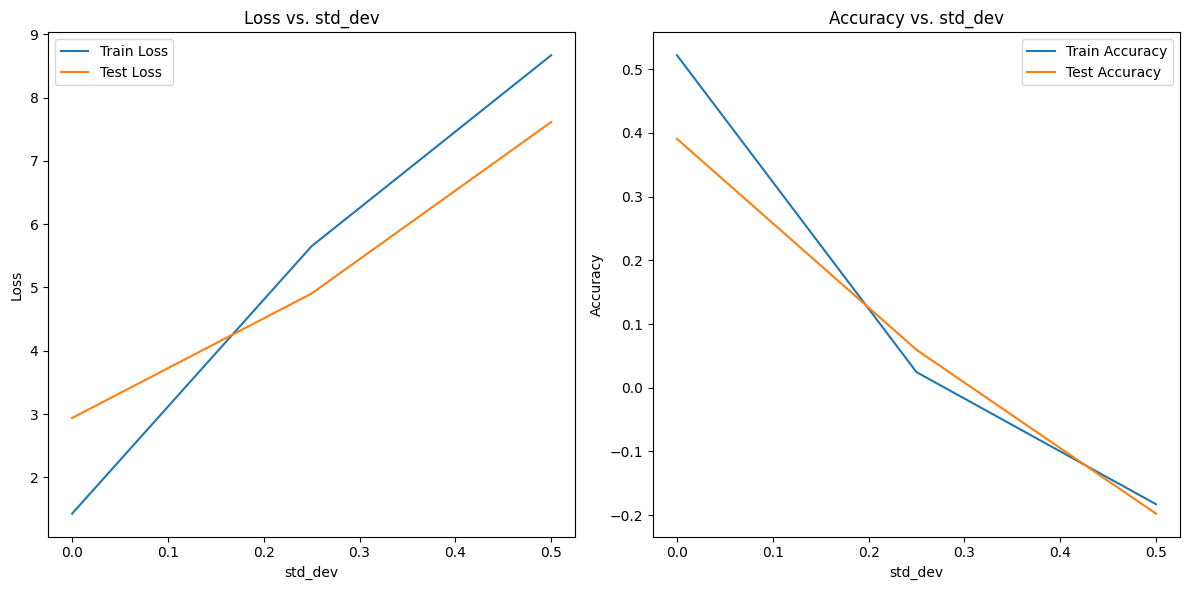

In [22]:
import os

# Define the range of std_dev values to explore
stddev_num_intervals = 11  # Adjust the number of intervals as needed
std_dev_range = np.linspace(0, 1, stddev_num_intervals)  # Generate values from 0 to 0.2 with stddev_num_intervals intervals


best_std_dev = None
best_loss = float('inf')
best_accuracy = 0
best_train_loss = float('inf')
best_train_accuracy = 0
# Lists to store metrics
std_dev_values = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Number of grid search iterations
num_iterations = stddev_num_intervals  # One iteration per std_dev value

for std_dev in std_dev_range:
    # Reset network and optimizer for each std_dev value
    net = SAE().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001)

    # Create a folder to save intermediate layers for the current std_dev
    intermediate_layers_dir = f"Intermediate_Lyrs/std_dev_{std_dev}"
    os.makedirs(intermediate_layers_dir, exist_ok=True)
    print('\n--------------------------------------This shows the std_dev has been changed --------------------------------------\n')

    # Run training and testing
    for e in range(epochs):
        train_loss, train_loss_rec, train_accuracy, epoch_loss, epoch_accuracy, out, out_en = train(net, train_loader, optimizer, e, std_dev)
        # train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

        test_loss, test_loss_rec, test_accuracy, epoch_loss_test, epoch_accuracy_test, out, out_en = test(net, test_loader, optimizer, e, std_dev)
        # print('-------------------')
        # print('test_loss: ', test_loss)
        # print('test_loss.item(): ', test_loss.item())
        # print('test_accuracy[-1]: ', test_accuracy[-1])
        # # print('epoch_loss_test: ', epoch_loss_test)
        # # print('epoch_accuracy_test: ', epoch_accuracy_test)
        # print('-------------------')

        # Save intermediate layers every 10 epochs
        if (e + 1) % 10 == 0:
            activations_path = f"{intermediate_layers_dir}/activations_epoch_{e + 1}.pkl"
            with open(activations_path, 'wb') as file:
                pickle.dump(epoch_activations, file)

    # Evaluate performance with the current std_dev based on the last epoch
    print('test_loss.item():', test_loss.item())
    print('best_loss:',best_loss)
    print('test_accuracy[-1]:', test_accuracy[-1])
    print('best_accuracy:', best_accuracy)
    # print('best_accuracy[-1]:', best_accuracy[-1])

    # Record metrics
    std_dev_values.append(std_dev)
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_accuracy[-1])
    test_accuracies.append(test_accuracy[-1])

    if test_loss.item() < best_loss and test_accuracy[-1] > best_accuracy:
      best_std_dev = std_dev
      best_loss = test_loss.item()
      best_accuracy = test_accuracy[-1]
      best_train_loss = train_loss.item()
      best_train_accuracy = train_accuracy[-1]

    print('---------------------------------------------------------------------------------------\n')
    # print(f"std_dev={std_dev}, train_loss= {train_loss:.4f}, test_loss= {test_loss:.4f}, train_accuracy= {train_accuracy:.4f}%, test_accuracy= {test_accuracy:.4f}%")
    print(f"std_dev={std_dev}-------, train_loss= {train_loss.item():.4f} , test_loss= {test_loss.item():.4f}, train_accuracy= {train_accuracy[-1]*100:.4f}%, test_accuracy= {test_accuracy[-1]*100:.4f}%")
    print('---------------------------------------------------------------------------------------\n')


print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n')
print(f"Best std_dev: {best_std_dev}, Best train_loss: {best_train_loss:.4f}, Best test_loss: {best_loss:.4f}, Best train_accuracy: {best_train_accuracy*100:.4f}%, Best test_accuracy: {best_accuracy*100:.4f}%")
print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\n')


# ----------------------------------------------------------------------------------Plotting the results
plt.figure(figsize=(12, 6))
# fig, axs = plt.subplots(2, 1, figsize=(6, 12))
font_size = 15
font = {'weight': 'bold', 'size': 22}
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(std_dev_values, train_losses, label='Train Loss')
plt.plot(std_dev_values, test_losses, label='Test Loss')
plt.xlabel('std_dev', fontweight="bold", fontdict=font)
plt.ylabel('Loss', fontweight="bold", fontdict=font)
plt.title('Loss vs. std_dev', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
plt.legend(fontsize='large')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(std_dev_values, train_accuracies, label='Train Accuracy')
plt.plot(std_dev_values, test_accuracies, label='Test Accuracy')
plt.xlabel('std_dev', fontweight="bold", fontdict=font)
plt.ylabel('Accuracy (%)', fontweight="bold", fontdict=font)
plt.title('Accuracy vs. std_dev', fontweight="bold", fontdict=font)
plt.tick_params(labelsize=font_size)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())  # Format y-axis as percentage
plt.legend(fontsize='large')

plt.tight_layout()
plt.show()


In [23]:
print("Best std_dev: 0.046153846153846156, Best train_loss: 0.5006, Best test_loss: 0.4890, Best train_accuracy: 84.0904%, Best test_accuracy: 85.7873%")
print('std_dev=0.34177215189873417-------, train_loss= 1.3233 , test_loss= 0.4465, train_accuracy= 61.7785%, test_accuracy= 82.8034%')
print('std_dev=0.7215189873417721-------, train_loss= 3.6373 , test_loss= 0.4894, train_accuracy= 32.9415%, test_accuracy= 85.8028%')

Best std_dev: 0.046153846153846156, Best train_loss: 0.5006, Best test_loss: 0.4890, Best train_accuracy: 84.0904%, Best test_accuracy: 85.7873%
std_dev=0.34177215189873417-------, train_loss= 1.3233 , test_loss= 0.4465, train_accuracy= 61.7785%, test_accuracy= 82.8034%
std_dev=0.7215189873417721-------, train_loss= 3.6373 , test_loss= 0.4894, train_accuracy= 32.9415%, test_accuracy= 85.8028%


### Random Search


In [18]:


# # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# import random

# # Define the range of std_dev values to explore
# stddev_num_intervals = 20  # Adjust the number of intervals as needed

# # Define the range of std_dev values to explore
# std_dev_range = np.linspace(0, 0.2, stddev_num_intervals)  # Generate values from 0 to 2 with stddev_num_intervals intervals


# best_std_dev = None
# best_loss = float('inf')
# best_accuracy = 0.0

# # Number of random search iterations
# num_iterations = 10  # Adjust as needed

# # # -----------------------------------------------
# for i in range(num_iterations):
#     # Sample a value for std_dev
#     std_dev = np.random.choice(std_dev_range)

#     # Update std_dev in your code
#     std_dev = std_dev

#     # Reset network and optimizer
#       #Define Network and optimizer
#     net=SAE()
#     net = net.to(device)
#     optimizer = torch.optim.AdamW(net.parameters(),
#                             lr=0.0001,
#                             betas=(0.9, 0.999),
#                             weight_decay=0.001)

#     # Create a folder to save intermediate layers for the current std_dev
#     intermediate_layers_dir = f"Intermediate_Lyrs/std_dev_{std_dev}"
#     os.makedirs(intermediate_layers_dir, exist_ok=True)

#     # Run training and testing
#     for e in range(epochs):
#         train_loss, train_loss_rec, train_accuracy, epoch_loss, epoch_accuracy, out, out_en = train(net, train_loader, optimizer, e)
#         train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

#         test_loss, test_loss_rec, test_accuracy, epoch_loss_test, epoch_accuracy_test, out, out_en = test(net, test_loader, optimizer, e)
#         test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

#         # Access activations and save them
#         epoch_activations[e] = {}
#         for i, name in enumerate(hook_names):
#             epoch_activations[e][name] = activation.get(name, None)  # Use get to avoid KeyError

#         # Save intermediate layers every 10 epochs
#         if (e + 1) % 10 == 0:
#             # activations_path = Intermediate_Lyrs + f"activations_epoch_{e + 1}.pkl"
#             activations_path = f"{intermediate_layers_dir}/activations_epoch_{e + 1}.pkl"
#             with open(activations_path, 'wb') as file:
#                 pickle.dump(epoch_activations, file)

#     # Evaluate performance with the current std_dev
#     avg_test_accuracy = np.mean(test_accuracy)  # Calculate average test accuracy over all epochs
#     if test_loss < best_loss and avg_test_accuracy > best_accuracy:
#         best_std_dev = std_dev
#         best_loss = test_loss
#         best_accuracy = avg_test_accuracy

#     print(f"Iteration {i + 1}: std_dev={std_dev}, test_loss={test_loss}, test_accuracy={avg_test_accuracy}")

# print(f"Best std_dev: {best_std_dev}, Best test_loss: {best_loss}, Best test_accuracy: {best_accuracy}")




In [19]:
# def train_and_evaluate(std_dev):
#     # Your training and evaluation code here
#     # Run training and testing
#     for e in range(epochs):
#         train_loss, train_loss_rec, train_accuracy, epoch_loss, epoch_accuracy, out, out_en = train(net, train_loader, optimizer, e, std_dev)
#         train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

#         test_loss, test_loss_rec, test_accuracy, epoch_loss_test, epoch_accuracy_test, out, out_en = test(net, test_loader, optimizer, e, std_dev)
#         test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

#         # Intermediate Layers
#         # Check if the current epoch is a multiple of 10
#         if (e + 1) % 10 == 0:
#             # Save the epoch_activations dictionary to a file
#             activations_path = Intermediate_Lyrs +  f"activations_epoch_{e + 1}.pkl"
#             with open(activations_path, 'wb') as file:
#                 pickle.dump(epoch_activations, file)

#         # Capture activations for the current epoch
#         epoch_activations[e] = {}
#         for i, name in enumerate(hook_names):
#             epoch_activations[e][name] = activation.get(name, None)  # Use get to avoid KeyError


#     # Update the std_dev parameter with the value provided by Bayesian Optimization
#     std_dev = std_dev

#     # Run training and testing with the updated std_dev
#     # Call the train and test functions with the updated std_dev
#     train_loss, train_loss_rec, train_accuracy, epoch_loss, epoch_accuracy, out, out_en = train(net, train_loader, optimizer, e, std_dev)
#     test_loss, test_loss_rec, test_accuracy, epoch_loss_test, epoch_accuracy_test, out, out_en = test(net, test_loader, optimizer, e, std_dev)
#     return test_accuracy  # Return the evaluation metric you want to optimize (e.g., accuracy)

# # Define the bounds for std_dev
# pbounds = {'std_dev': (0.0, 0.2)}  # Adjust the bounds as needed

# # Create the Bayesian Optimization object
# optimizer = BayesianOptimization(
#     f=train_and_evaluate,
#     pbounds=pbounds,
#     verbose=2,  # Adjust verbosity as needed
#     random_state=42,  # Set a random seed for reproducibility
# )

# # Run optimization
# optimizer.maximize(
#     init_points=5,  # Number of random initialization points
#     n_iter=10,  # Number of optimization iterations
# )

# # Retrieve the optimal value for std_dev and the corresponding test accuracy
# optimal_std_dev = optimizer.max['params']['std_dev']
# optimal_test_accuracy = optimizer.max['target']

# print("Optimal std_dev:", optimal_std_dev)
# print("Corresponding test accuracy:", optimal_test_accuracy)





### Basic original

In [20]:
# std_dev = 0.5
# # Run training and testing
# for e in range(epochs):
#     train_loss, train_loss_rec, train_accuracy, epoch_loss, epoch_accuracy, out, out_en = train(net, train_loader, optimizer, e, std_dev)
#     train_avg_loss_rec.append(sum(train_loss_rec) / len(train_loader))

#     test_loss, test_loss_rec, test_accuracy, epoch_loss_test, epoch_accuracy_test, out, out_en = test(net, test_loader, optimizer, e, std_dev)
#     test_avg_loss_rec.append(sum(test_loss_rec) / (len(test_loader)))

#     # # #---------------------------------------------------------- Access the out_en tensor
#     out_en = net.out_en
#     out_en_numpy = out_en.cpu().detach().numpy()
#     # Save with a different name for each epoch
#     out_en_filename = Output_Spikes + f"out_en_epoch_{e + 1}.npy"
#     np.save(out_en_filename, out_en_numpy)



#     # #-----------------------------------------------------------Access the out tensor
#     out = net.out
#     out_numpy = out.cpu().detach().numpy()
#     # Save with a different name for each epoch
#     out_filename = Output_Spikes + f"out_epoch_{e + 1}.npy"
#     np.save(out_filename, out_numpy)
#     # -------------------------------------------------------------------- Intermediate Layers
# # Check if the current epoch is a multiple of 10
#     if (e + 1) % 10 == 0:
#         # Save the epoch_activations dictionary to a file
#         activations_path = Intermediate_Lyrs +  f"activations_epoch_{e + 1}.pkl"
#         with open(activations_path, 'wb') as file:
#             pickle.dump(epoch_activations, file)
#     # Capture activations for the current epoch
#     epoch_activations[e] = {}
#     for i, name in enumerate(hook_names):
#         epoch_activations[e][name] = activation.get(name, None)  # Use get to avoid KeyError






# # # beta_syn=0.0001
